## Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [37]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [38]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [39]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 32
Matching on title: 65
Total matches: 97, 57.74% of total


In [40]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [41]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [42]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [43]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [65]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0], color="tab:blue"
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1], color="tab:orange"
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

In [45]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

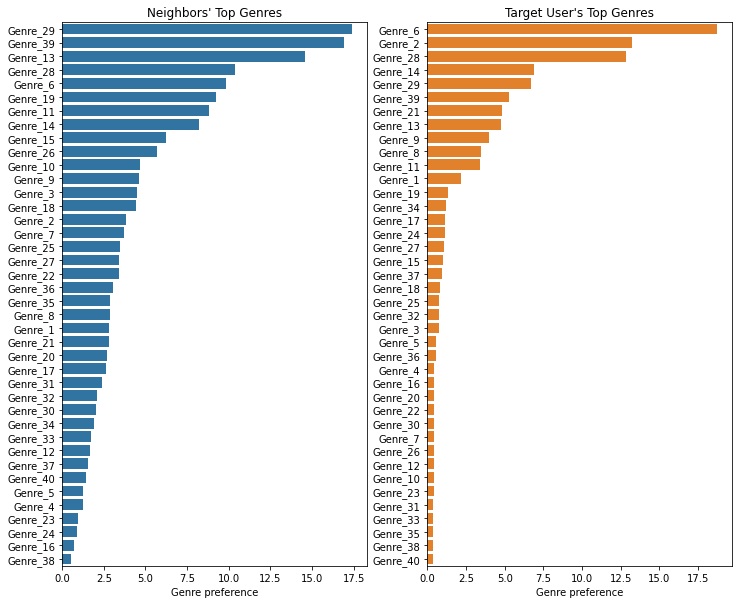

In [66]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [47]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
45,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,3.3%,https://www.goodreads.com/book/show/6437061-th...
25,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.7%,https://www.goodreads.com/book/show/24611623-i...
4,Assata: An Autobiography,4.47,11057.0,1999,1.7%,https://www.goodreads.com/book/show/100322.Assata
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.7%,https://www.goodreads.com/book/show/27220736-s...
5,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,1.7%,https://www.goodreads.com/book/show/18687079-a...
12,Daytripper,4.31,18265.0,2011,1.7%,https://www.goodreads.com/book/show/8477057-da...
18,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,2006,1.7%,https://www.goodreads.com/book/show/4373.First...
56,Totto-chan: The Little Girl at the Window,4.30,14456.0,1996,1.7%,https://www.goodreads.com/book/show/328802.Tot...
40,The Cartel,4.29,9961.0,2015,1.7%,https://www.goodreads.com/book/show/23602561-t...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,1.7%,https://www.goodreads.com/book/show/26863057-a...


In [48]:
# View highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
25,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
4,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
5,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,https://www.goodreads.com/book/show/18687079-a...
12,Daytripper,4.31,18265.0,2011,https://www.goodreads.com/book/show/8477057-da...
18,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,2006,https://www.goodreads.com/book/show/4373.First...
56,Totto-chan: The Little Girl at the Window,4.30,14456.0,1996,https://www.goodreads.com/book/show/328802.Tot...
40,The Cartel,4.29,9961.0,2015,https://www.goodreads.com/book/show/23602561-t...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,https://www.goodreads.com/book/show/26863057-a...
57,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,1996,https://www.goodreads.com/book/show/43841.When...


In [49]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
8,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
9,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
7,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
3,Em and The Big Hoom,4.07,2282.0,https://www.goodreads.com/book/show/13601144-e...
1,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
6,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
4,Rolling in the Deep (Rolling in the Deep #0.5),3.94,1569.0,https://www.goodreads.com/book/show/23634011-r...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
2,"Wool Omnibus (Silo, #1)",4.24,83601.0,https://www.goodreads.com/book/show/13453029-w...
1,Pandemic (The Extinction Files #1),4.11,7066.0,https://www.goodreads.com/book/show/34811896-p...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
7,New Seeds of Contemplation,4.31,913.0,https://www.goodreads.com/book/show/1145854.Ne...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
3,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
1,Dirt: The Erosion of Civilizations,3.94,736.0,https://www.goodreads.com/book/show/587916.Dirt
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
9,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
6,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
0,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,https://www.goodreads.com/book/show/17836520-a...
3,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
9,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
5,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...
7,The Affirmation,3.92,893.0,https://www.goodreads.com/book/show/106925.The...
1,Books v. Cigarettes,3.91,2683.0,https://www.goodreads.com/book/show/4064936-bo...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
8,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
6,I Have Lived a Thousand Years,4.16,16409.0,https://www.goodreads.com/book/show/48834.I_Ha...
17,The Woman on the Orient Express,4.15,2305.0,https://www.goodreads.com/book/show/29806077-t...
0,Beyond the Sky and the Earth: A Journey into B...,4.13,2641.0,https://www.goodreads.com/book/show/145249.Bey...
18,Those Who Save Us,4.12,4984.0,https://www.goodreads.com/book/show/10316205-t...
19,Time Stops at Shamli and Other Stories,4.11,1091.0,https://www.goodreads.com/book/show/475218.Tim...
11,Stag's Leap: Poems,4.10,1975.0,https://www.goodreads.com/book/show/13330670-s...
16,The Shell Collector,4.06,4771.0,https://www.goodreads.com/book/show/883235.The...
5,"Go Down, Moses",3.93,7562.0,https://www.goodreads.com/book/show/17726.Go_D...
20,Who Asked You?,3.93,3428.0,https://www.goodreads.com/book/show/17572866-w...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [50]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
svd_neighborhood_ratings, target_user_ratings = find_neighbors(
                                                    1500, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [51]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"\nNeighborhood contains {svd_neighborhood_ratings.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]


Neighborhood contains 8638 books


In [52]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [53]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [54]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [55]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
6,Night (The Night Trilogy #1),4.30,0.421127,708754.0,1958,https://www.goodreads.com/book/show/1617.Night
7,I Am Malala: The Story of the Girl Who Stood U...,4.07,0.419435,228884.0,2013,https://www.goodreads.com/book/show/17851885-i...
8,"Wool Omnibus (Silo, #1)",4.24,0.312537,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...
11,Bad Feminist,3.91,0.271999,43988.0,2014,https://www.goodreads.com/book/show/18813642-b...
12,"The Pillars of the Earth (Kingsbridge, #1)",4.29,0.255598,471990.0,2002,https://www.goodreads.com/book/show/5043.The_P...
14,"Adulthood Is a Myth (Sarah's Scribbles, #1)",4.15,0.234216,43628.0,2016,https://www.goodreads.com/book/show/25855506-a...
15,Talking as Fast as I Can: From Gilmore Girls t...,4.03,0.233900,35052.0,2016,https://www.goodreads.com/book/show/30253864-t...
16,"Rich Dad, Poor Dad",3.96,0.219367,164543.0,2007,https://www.goodreads.com/book/show/69571.Rich...
19,Understanding Comics: The Invisible Art,3.98,0.214614,80348.0,1994,https://www.goodreads.com/book/show/102920.Und...
22,All the Ugly and Wonderful Things,4.10,0.202358,35002.0,2016,https://www.goodreads.com/book/show/26114135-a...


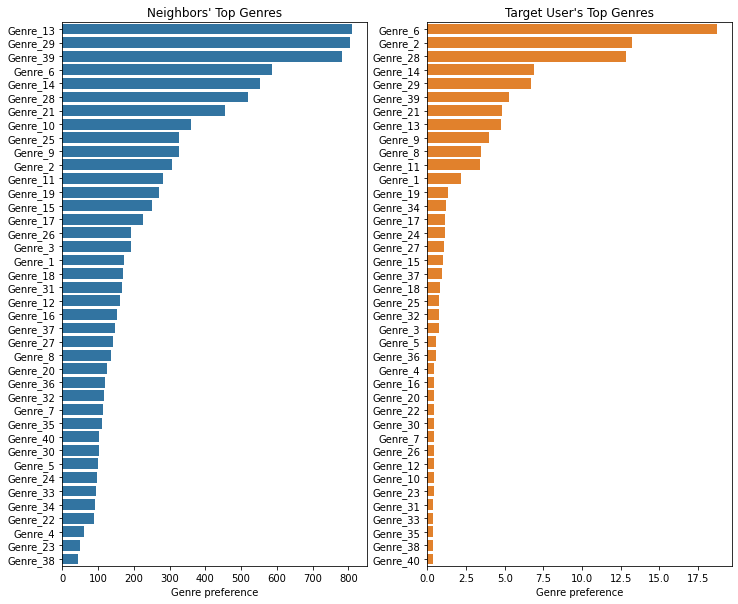

In [67]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [57]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=2000, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
650,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,2.3%,https://www.goodreads.com/book/show/17851885-i...
887,Night (The Night Trilogy #1),4.30,708754.0,1958,1.6%,https://www.goodreads.com/book/show/1617.Night
175,Bad Feminist,3.91,43988.0,2014,1.5%,https://www.goodreads.com/book/show/18813642-b...
1880,Wonder (Wonder #1),4.43,255461.0,2012,1.3%,https://www.goodreads.com/book/show/11387515-w...
109,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.3%,https://www.goodreads.com/book/show/26114135-a...
1163,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.3%,https://www.goodreads.com/book/show/30253864-t...
1545,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.2%,https://www.goodreads.com/book/show/5043.The_P...
1883,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.2%,https://www.goodreads.com/book/show/13453029-w...
1400,The Gunslinger,3.98,346978.0,1982,1.2%,https://www.goodreads.com/book/show/43615.The_...
1003,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.2%,https://www.goodreads.com/book/show/69571.Rich...


In [58]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=2000, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
1436,The Indispensable Calvin and Hobbes,4.73,14791.0,1992,https://www.goodreads.com/book/show/24815.The_...
1028,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
28,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,2004,https://www.goodreads.com/book/show/4700482-a-...
1697,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1327,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,1988,https://www.goodreads.com/book/show/43070.The_...
271,Calvin and Hobbes,4.61,120371.0,1987,https://www.goodreads.com/book/show/77727.Calv...
608,Holy Bible: New International Version,4.61,42213.0,1985,https://www.goodreads.com/book/show/280111.Hol...
76,"A Voice in the Wind (Mark of the Lion, #1)",4.59,57014.0,1993,https://www.goodreads.com/book/show/95617.A_Vo...
711,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,2012,https://www.goodreads.com/book/show/30.J_R_R_T...
1346,The Feynman Lectures on Physics,4.59,5652.0,1964,https://www.goodreads.com/book/show/5546.The_F...


In [68]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.15, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
44,It's What I Do: A Photographer's Life of Love ...,4.31,6016.0,https://www.goodreads.com/book/show/22571757-i...
200,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
202,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
320,Economics in One Lesson: The Shortest & Surest...,4.22,9336.0,https://www.goodreads.com/book/show/3028.Econo...
545,A Fighting Chance,4.17,8740.0,https://www.goodreads.com/book/show/18779662-a...
582,Auschwitz: A Doctor's Eyewitness Account,4.24,8525.0,https://www.goodreads.com/book/show/315578.Aus...
590,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
592,All the Shah's Men: An American Coup and the R...,4.22,4222.0,https://www.goodreads.com/book/show/46347.All_...
595,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
649,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
8,"Wool Omnibus (Silo, #1)",4.24,83601.0,https://www.goodreads.com/book/show/13453029-w...
157,"Steelheart (The Reckoners, #1)",4.16,79287.0,https://www.goodreads.com/book/show/17182126-s...
218,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
360,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
385,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
397,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
816,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
1569,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
2109,South: The Story of Shackleton's Last Expediti...,4.21,4715.0,https://www.goodreads.com/book/show/143999.South
2119,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
56,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
58,Complications: A Surgeon's Notes on an Imperfe...,4.24,26885.0,https://www.goodreads.com/book/show/4477.Compl...
77,Harry Potter and the Methods of Rationality,4.38,8691.0,https://www.goodreads.com/book/show/10016013-h...
108,"Delusions of Gender: How Our Minds, Society, a...",4.16,4207.0,https://www.goodreads.com/book/show/8031168-de...
275,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
276,Why Evolution Is True,4.16,15226.0,https://www.goodreads.com/book/show/4005310-wh...
482,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
851,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
1186,The Butter Battle Book,4.18,10575.0,https://www.goodreads.com/book/show/275325.The...
1362,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
57,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
63,Sounds Like Me: My Life (So Far) in Song,4.26,3867.0,https://www.goodreads.com/book/show/25434361-s...
232,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
242,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
517,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
829,In the Footsteps of the Prophet: Lessons from ...,4.41,2365.0,https://www.goodreads.com/book/show/169338.In_...
1100,The True Believer: Thoughts on the Nature of M...,4.23,3244.0,https://www.goodreads.com/book/show/15916.The_...
1208,Arguably: Selected Essays,4.19,6061.0,https://www.goodreads.com/book/show/10383597-a...
1383,Hopscotch,4.25,10523.0,https://www.goodreads.com/book/show/53413.Hops...
1458,The Road to Mecca,4.43,2322.0,https://www.goodreads.com/book/show/362413.The...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
6,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
28,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
50,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
133,Swami and Friends,4.21,8253.0,https://www.goodreads.com/book/show/732482.Swa...
148,Transformations,4.21,4691.0,https://www.goodreads.com/book/show/47734.Tran...
184,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
274,These Is My Words: The Diary of Sarah Agnes Pr...,4.34,44889.0,https://www.goodreads.com/book/show/348225.The...
284,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
286,I Know Why the Caged Bird Sings (Maya Angelou'...,4.19,2146.0,https://www.goodreads.com/book/show/215575.I_K...
343,Felicity,4.27,2390.0,https://www.goodreads.com/book/show/24611522-f...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [60]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
gd_neighborhoodhood_ratings, target_user_ratings = find_neighbors(
                                                        1000, target, df_reviews_norm, book_index, df_books)

# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"\nNeighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]



Neighborhood contains 3865 books


In [61]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [70]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.009, 
                                    beta=0.05,
                                    decay=True, 
                                    steps=6000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 432243.63, lr: 0.00900
Step: 1000, error: 4757.30, lr: 0.00450
Step: 2000, error: 4006.69, lr: 0.00225
Step: 3000, error: 3779.43, lr: 0.00112
Step: 4000, error: 3693.16, lr: 0.00056
Step: 5000, error: 3655.92, lr: 0.00028
Step: 6000, error: 3638.68, lr: 0.00014


In [71]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.1 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
25,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,4.564714,95353.0,1997,https://www.goodreads.com/book/show/5544.Surel...
26,Just Do Something: A Liberating Approach to Fi...,4.22,4.502869,6663.0,2009,https://www.goodreads.com/book/show/5466804-ju...
29,"Scythe (Arc of a Scythe, #1)",4.30,4.400396,13000.0,2016,https://www.goodreads.com/book/show/28954189-s...
31,Open,4.18,4.382075,48230.0,2009,https://www.goodreads.com/book/show/6480781-open
49,Ego Is the Enemy,4.12,4.203520,11380.0,2016,https://www.goodreads.com/book/show/27036528-e...
52,"Avatar: The Last Airbender: The Promise, Part ...",4.24,4.180151,18987.0,2012,https://www.goodreads.com/book/show/12413836-a...
55,Chesapeake,4.15,4.166877,15932.0,1978,https://www.goodreads.com/book/show/12661.Ches...
59,Cravings: Recipes for All the Food You Want to...,4.23,4.154723,6301.0,2016,https://www.goodreads.com/book/show/25982685-c...
60,The Fire This Time: A New Generation Speaks ab...,4.35,4.152041,2309.0,2016,https://www.goodreads.com/book/show/28505023-t...
76,Batman: Hush,4.29,4.087936,25146.0,2009,https://www.goodreads.com/book/show/6375845-ba...


In [72]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
60,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
82,Nine Parts of Desire: The Hidden World of Isla...,4.04,10469.0,https://www.goodreads.com/book/show/337615.Nin...
120,Most Dangerous: Daniel Ellsberg and the Secret...,4.24,2888.0,https://www.goodreads.com/book/show/23310694-m...
256,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
265,Tribe: On Homecoming and Belonging,4.04,10078.0,https://www.goodreads.com/book/show/28119237-t...
304,"Republic, Lost: How Money Corrupts Congress--a...",4.15,2109.0,https://www.goodreads.com/book/show/11814478-r...
336,Killing Patton: The Strange Death of World War...,4.08,14192.0,https://www.goodreads.com/book/show/22381892-k...
360,A Fighting Chance,4.17,8740.0,https://www.goodreads.com/book/show/18779662-a...
372,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
485,Gorillas in the Mist,4.16,16694.0,https://www.goodreads.com/book/show/232577.Gor...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
52,"Avatar: The Last Airbender: The Promise, Part ...",4.24,18987.0,https://www.goodreads.com/book/show/12413836-a...
109,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
148,"Steelheart (The Reckoners, #1)",4.16,79287.0,https://www.goodreads.com/book/show/17182126-s...
236,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
477,"Tin Stars (Descender, #1)",4.12,7746.0,https://www.goodreads.com/book/show/25546167-d...
506,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
618,"Zita the Spacegirl (Zita the Spacegirl, #1)",4.05,11255.0,https://www.goodreads.com/book/show/8879121-zi...
623,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
769,"Day by Day Armageddon (Day by Day Armageddon,#1)",4.01,11808.0,https://www.goodreads.com/book/show/74821.Day_...
772,Fingerprints of the Gods: The Evidence of Eart...,4.17,5510.0,https://www.goodreads.com/book/show/53325.Fing...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
25,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
176,The Book on the Taboo Against Knowing Who You Are,4.28,10108.0,https://www.goodreads.com/book/show/60551.The_...
278,The Varieties of Religious Experience,4.04,6745.0,https://www.goodreads.com/book/show/28820.The_...
314,The Age of Reason,4.13,5320.0,https://www.goodreads.com/book/show/1031803.Th...
374,The Ideological Origins of the American Revolu...,4.02,3071.0,https://www.goodreads.com/book/show/22477.The_...
377,Escape from Freedom,4.23,5910.0,https://www.goodreads.com/book/show/25491.Esca...
426,The Butter Battle Book,4.18,10575.0,https://www.goodreads.com/book/show/275325.The...
486,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya
499,Sita: An Illustrated Retelling of the Ramayana,4.02,3685.0,https://www.goodreads.com/book/show/18514068-sita
541,"The Story of the Human Body: Evolution, Health...",4.21,2759.0,https://www.goodreads.com/book/show/17736859-t...


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
49,Ego Is the Enemy,4.12,11380.0,https://www.goodreads.com/book/show/27036528-e...
108,"Harry, a History: The True Story of a Boy Wiza...",4.09,12587.0,https://www.goodreads.com/book/show/3130430-ha...
149,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
247,The True Believer: Thoughts on the Nature of M...,4.23,3244.0,https://www.goodreads.com/book/show/15916.The_...
429,Natasha's Dance: A Cultural History of Russia,4.16,2039.0,https://www.goodreads.com/book/show/97401.Nata...
505,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...
509,Sam Walton: Made In America,4.08,9761.0,https://www.goodreads.com/book/show/10631.Sam_...
547,"At the Existentialist Café: Freedom, Being, an...",4.22,2298.0,https://www.goodreads.com/book/show/25658482-a...
661,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
784,Adventures in the Screen Trade,4.15,3670.0,https://www.goodreads.com/book/show/459744.Adv...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
31,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
151,The Seven Good Years,4.16,2373.0,https://www.goodreads.com/book/show/23399025-t...
227,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
258,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...
260,We Are Never Meeting In Real Life,4.02,4864.0,https://www.goodreads.com/book/show/33381433-w...
305,The Yellow Wall-Paper,4.11,45971.0,https://www.goodreads.com/book/show/286957.The...
361,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
538,"Sing, Unburied, Sing",4.12,4592.0,https://www.goodreads.com/book/show/32920226-s...
606,Ocean Sea,4.13,5825.0,https://www.goodreads.com/book/show/208631.Oce...
650,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url


_____

Genre 21: ['collection', 'short', 'poem', 'text', 'includes', 'classic', 'introduction', 'fiction', 'writing', 'feature']


,title,avg_rating,ratings_count,url
207,Apology,4.15,19111.0,https://www.goodreads.com/book/show/73945.Apology
362,Avatar: The Last Airbender (The Art of the Ani...,4.50,15507.0,https://www.goodreads.com/book/show/7642606-av...
517,Collected Poems,4.26,5180.0,https://www.goodreads.com/book/show/321538.Col...
559,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
633,Kon-Tiki: Across The Pacific In A Raft,4.10,13778.0,https://www.goodreads.com/book/show/790171.Kon...
677,Her Smoke Rose Up Forever,4.22,2539.0,https://www.goodreads.com/book/show/27059.Her_...
719,"The Camera (Ansel Adams Photography, #1)",4.22,2663.0,https://www.goodreads.com/book/show/20501.The_...
721,Make Way for Ducklings,4.22,71133.0,https://www.goodreads.com/book/show/29291.Make...
726,Make Good Art,4.30,5677.0,https://www.goodreads.com/book/show/16240792-m...
836,The Trial and Death of Socrates,4.07,22194.0,https://www.goodreads.com/book/show/22632.The_...


_____

Genre 13: ['guide', 'help', 'people', 'way', 'practical', 'experience', 'spiritual', 'offer', 'advice', 'learn']


,title,avg_rating,ratings_count,url
79,365 Days of Wonder: Mr. Browne's Book of Precepts,4.34,4920.0,https://www.goodreads.com/book/show/20758093-3...
88,The Crossroads of Should and Must: Find and Fo...,4.04,5463.0,https://www.goodreads.com/book/show/22859551-t...
90,Just Listen: Discover the Secret to Getting Th...,4.10,3846.0,https://www.goodreads.com/book/show/6547576-ju...
154,Courage: The Joy of Living Dangerously,4.26,3022.0,https://www.goodreads.com/book/show/96999.Courage
246,How to Have Confidence and Power in Dealing wi...,4.25,7005.0,https://www.goodreads.com/book/show/320817.How...
267,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,https://www.goodreads.com/book/show/23500254-t...
272,A Praying Life: Connecting with God in a Distr...,4.30,7482.0,https://www.goodreads.com/book/show/6426403-a-...
325,Radical Acceptance: Embracing Your Life With t...,4.25,8593.0,https://www.goodreads.com/book/show/173666.Rad...
326,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
380,The Jesus I Never Knew,4.18,15106.0,https://www.goodreads.com/book/show/53834.The_...


_____

Genre 9: ['epic', 'family', 'saga', 'world', 'history', 'young', 'war', 'historical', 'century', 'adventure']


,title,avg_rating,ratings_count,url
55,Chesapeake,4.15,15932.0,https://www.goodreads.com/book/show/12661.Ches...
61,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,https://www.goodreads.com/book/show/15819028-t...
348,The Indifferent Stars Above: The Harrowing Sag...,4.06,2974.0,https://www.goodreads.com/book/show/6033525-th...
448,The War that Saved My Life (The War That Saved...,4.44,21307.0,https://www.goodreads.com/book/show/20912424-t...
579,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
588,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
705,The Amazing Story of Adolphus Tips,4.03,4058.0,https://www.goodreads.com/book/show/1527413.Th...
715,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
809,"Kane and Abel (Kane and Abel, #1)",4.27,75215.0,https://www.goodreads.com/book/show/78983.Kane...
849,Evidence Not Seen: A Woman's Miraculous Faith ...,4.51,3581.0,https://www.goodreads.com/book/show/213916.Evi...


_____

Genre 8: ['agent', 'mission', 'terrorist', 'secret', 'spy', 'assassin', 'government', 'deadly', 'team', 'dangerous']


,title,avg_rating,ratings_count,url
103,Arch of Triumph: A Novel of a Man Without a Co...,4.40,11703.0,https://www.goodreads.com/book/show/672948.Arc...
321,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
727,Harrison Bergeron,4.23,10690.0,https://www.goodreads.com/book/show/10176119-h...
1251,"The Cartel (The Cartel, #1)",4.58,5703.0,https://www.goodreads.com/book/show/5953477-th...
1363,"Hawkeye, Volume 1: My Life as a Weapon",4.16,33359.0,https://www.goodreads.com/book/show/16002136-h...
1856,Chasing the Scream: The First and Last Days of...,4.49,5296.0,https://www.goodreads.com/book/show/22245552-c...
3583,"Orphan X (Orphan X, #1)",4.08,11229.0,https://www.goodreads.com/book/show/25663888-o...
3669,"The Eagle Has Landed (Liam Devlin, #1)",4.15,42409.0,https://www.goodreads.com/book/show/295961.The...


_____

